In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Go to Kaggle Accounts and download a Kaggle API JSON file and upload it here 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunindsahu","key":"e82aea9778cc95c10497f534a94d4b53"}'}

In [ ]:
# Downloading our Credit Card Dataset from Kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 75.7MB/s]
100% 66.0M/66.0M [00:00<00:00, 134MB/s] 
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
df = pd.read_csv("creditcard.csv")
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Feature Engineering

In [ ]:
#Binning the Time Feature into 24 hours of day for 2 days
df.loc[:,'Time'] = np.floor(df['Time']/3600)%24
df['Time']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
284802    23.0
284803    23.0
284804    23.0
284805    23.0
284806    23.0
Name: Time, Length: 284807, dtype: float64

In [ ]:
# Code for dropping outliers

k = 2.5 #Threshold, Boxplot has k=1.5
pca_cols = [f'V{i}' for i in range(1,29)]

for col in pca_cols :
    # col0, col1 = df_0[col], df_1[col]
    q1, q3 = df.groupby('Class')[col].quantile(0.25)[0], df.groupby('Class')[col].quantile(0.75)[0]
    #q3_0, q3_1 = df.groupby('Class')[col].quantile(0.75)
    iqr = q3-q1 #Interquartile Ranges
    up, low = q3+k*iqr, q1-k*iqr
    
    #Drop all the outliers
    drop_index = df[((df[col]>up) | (df[col]<low)) & (df['Class']==0)].index
    df.drop(drop_index, inplace = True, errors = 'ignore')
    print(f'Rows Dropped for {col} = {len(drop_index)}\n')
   
m,n = df.shape
print(1-df.shape[0]/m, df1.shape[0], m)

Rows Dropped for V1 = 2791

Rows Dropped for V2 = 3969

Rows Dropped for V3 = 107

Rows Dropped for V4 = 856

Rows Dropped for V5 = 1480

Rows Dropped for V6 = 12435

Rows Dropped for V7 = 1234

Rows Dropped for V8 = 10479

Rows Dropped for V9 = 332

Rows Dropped for V10 = 1343

Rows Dropped for V11 = 0

Rows Dropped for V12 = 2567

Rows Dropped for V13 = 2

Rows Dropped for V14 = 2215

Rows Dropped for V15 = 45

Rows Dropped for V16 = 675

Rows Dropped for V17 = 392

Rows Dropped for V18 = 219

Rows Dropped for V19 = 1731

Rows Dropped for V20 = 7082

Rows Dropped for V21 = 580

Rows Dropped for V22 = 0

Rows Dropped for V23 = 2270

Rows Dropped for V24 = 223

Rows Dropped for V25 = 427

Rows Dropped for V26 = 466

Rows Dropped for V27 = 12522

Rows Dropped for V28 = 4735

0.0 224149 213630


In [ ]:
# Normalizing the Columns
pca_cols = [f'V{i}' for i in range(1,29)]
df.loc[:,pca_cols] = df[pca_cols]/df[pca_cols].std()

# Scaling the amount column
df['Amount'] = np.log(1+df['Amount'])
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000,213630.000000
mean,14.203731,0.409774,0.008413,0.096895,0.020881,-0.107136,-0.256797,0.002580,0.131145,-0.044095,-0.073307,0.012399,0.041629,-0.011389,0.007052,-0.018616,0.001094,-0.071849,-0.028001,-0.008165,-0.198874,-0.059712,-0.006173,-0.018926,-0.055251,0.021727,-0.000458,0.125015,0.135953,3.042139,0.002303
std,5.742464,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.526690,0.047935
min,0.000000,-23.375180,-9.336812,-23.122313,-3.688169,-23.463186,-7.493228,-51.870583,-84.424249,-13.457397,-30.048800,-3.082226,-20.097359,-3.956816,-23.219749,-5.076309,-17.005178,-32.594214,-11.643317,-5.044815,-16.163321,-71.427651,-13.191327,-82.790603,-3.949504,-10.487114,-3.515385,-49.195112,-19.679257,0.000000,0.000000
25%,10.000000,-0.436657,-0.608218,-0.519008,-0.596466,-0.724831,-0.911872,-0.588623,-0.358046,-0.633589,-0.615235,-0.762846,-0.397353,-0.686019,-0.473800,-0.651466,-0.530071,-0.628893,-0.624112,-0.575863,-0.789867,-0.676403,-0.806812,-0.606071,-0.639494,-0.658162,-0.681583,-0.383352,-0.457494,1.853168,0.000000
50%,15.000000,0.785923,0.020698,0.203833,0.043260,-0.128896,-0.404580,0.047989,0.034284,-0.062548,-0.129058,0.004068,0.180529,-0.013182,0.057956,0.036809,0.086295,-0.119955,-0.034542,0.015477,-0.305713,-0.103275,0.004382,-0.040529,0.045770,0.064667,-0.093085,0.013163,0.109478,3.045474,0.000000
75%,19.000000,1.302727,0.707965,0.789560,0.555571,0.464697,0.220048,0.607505,0.517591,0.549120,0.430866,0.756109,0.679935,0.674901,0.543371,0.693171,0.597961,0.441962,0.574733,0.590715,0.312405,0.509197,0.744848,0.557115,0.692320,0.754042,0.483660,0.484467,0.588632,4.230186,0.000000
max,23.000000,1.878231,24.511438,2.995455,9.367271,11.776515,7.572588,6.910010,41.152978,3.612128,4.926732,11.809758,2.873065,3.854084,4.160030,3.955424,3.778553,8.729750,4.646072,7.163691,43.299950,85.229786,12.412003,23.503935,2.286860,4.843089,5.879775,20.673428,18.732540,7.662407,1.000000


# TSNE Visualization

In [ ]:
!pip install MulticoreTSNE

In [ ]:
from MulticoreTSNE import MulticoreTSNE as tsne
tsne = tsne(n_components = 2, n_jobs = 2)

non_fraud = df[df['Class'] == 0].sample(2000)
fraud = df[df['Class'] == 1]
df_ = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df_.drop(['Class'], axis = 1).values
y = df_["Class"].values

X_embedded = tsne.fit_transform(X)

In [ ]:
np.where(y==1)[0].shape

(492,)

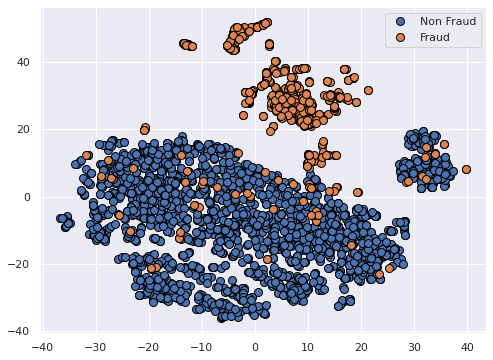

In [ ]:
def plot_embeddings(X_embedded, y):
    X_nonfraud = X_embedded[np.where(y==0)[0],:]
    X_fraud = X_embedded[np.where(y==1)[0],:]

    # Plotting Begins

    plt.subplots(figsize = (8,6))
    plt.plot(X_nonfraud[:,0], X_nonfraud[:,1],'o', mec = "black", mew=1, ms = 8, label = "Non Fraud")
    plt.plot(X_fraud[:,0], X_fraud[:,1], 'o', mec = "black", mew=1, ms = 8, label = "Fraud")
    plt.legend()
    plt.show()

plot_embeddings(X_embedded, y)

In [ ]:
drop_columns = ['V2','V5','V6','V7','V8','V13','V15','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
df_new = df.drop(drop_columns, axis = 1)

non_fraud = df_new[df_new['Class'] == 0].sample(4000)
fraud = df_new[df_new['Class'] == 1]
df_new_ = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X_new = df_.drop(['Class'], axis = 1).values
y_new = df_["Class"].values

X_embedded_new = tsne.fit_transform(X_new)

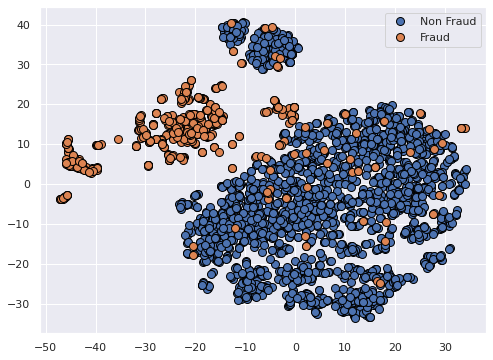

In [ ]:
plot_embeddings(X_embedded_new, y_new)

In [ ]:
X,y = np.array(X), np.array(y)
print(X.shape, y.shape)

(2492, 30) (2492,)


# AutoEncoder

In [ ]:
# Split Data into Train, Test and Validation 
from sklearn.model_selection import train_test_split
X_autoencoder = df[df['Class']==0] 

# Splitting X_non_fraud into Train-Validation-Test Pairs
X_train, X_test = train_test_split(X_autoencoder, test_size=0.4, shuffle = True)
X_val, X_test = train_test_split(X_test, test_size = 0.5, shuffle = True)
m_train, n = X_train.shape

In [ ]:
import torch
from torch import nn
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder_layer = torch.nn.Sequential(nn.Linear(n-1, 128), nn.Tanh(), 
                                                 nn.BatchNorm1d(128),
                                                 nn.Linear(128,64), nn.Tanh(),
                                                 nn.BatchNorm1d(64),
                                                 nn.Linear(64,32), nn.Tanh(),
                                                 nn.BatchNorm1d(32),
                                                 nn.Linear(32,16), nn.Tanh())
        
        self.decoder_layer = torch.nn.Sequential(nn.Linear(16,32), nn.Tanh(),
                                                 nn.BatchNorm1d(32),
                                                 nn.Linear(32,64), nn.Tanh(),
                                                 nn.BatchNorm1d(64),
                                                 nn.Linear(64,128), nn.Tanh(),
                                                 nn.Linear(128,n-1)) # Linear Activation since the values are real valued
    def forward(self, x):
        # Hidden Representation
        z = self.encoder_layer(x)
        # Reconstruction
        x_hat = self.decoder_layer(z)
        return x_hat

In [ ]:
import random
# Create Batches of the Data for the AutoEncoder
def create_batches(X_train, subsample=False, batch_size=128):
    # Have the option of only subsampling a small part of the X_train to train the Autoencoder
    if subsample:
        X_train = X_train.reset_index(drop = True)[:50000]
    else:
        X_train = X_train.reset_index(drop = True)
    
    # Creates Batches
    batches = []
    m,n = X_train.shape
    for batch_index in range(0, m, batch_size):
        if batch_index+batch_size < m :
            batches.append(torch.tensor(np.array(X_train.loc[batch_index:batch_index+batch_size, :]), dtype = torch.float32))
        else:
            batches.append(torch.tensor(np.array(X_train.loc[batch_index:, :]), dtype = torch.float32))
    return batches

trainloader = create_batches(X_train)
valloader = create_batches(X_val)

In [ ]:
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = autoencoder().to(device)

epochs = 15
loss_criterion = torch.nn.MSELoss() 
opt = torch.optim.AdamW(model.parameters(), lr = 0.0005, weight_decay = 1e-7) # Weight-Decay is L2 Regularization

train_loss_arr = []

# Returns Test and Train Loss for the Images
def evaluate(model, dataloader):
    model.eval()
    loss_total, num_ex_seen = 0,0

    for batch in dataloader:
        with torch.no_grad():
            x, label = batch[:,:n-1], batch[:,:n-1]
            # Calculating Total Loss
            x = x.to(device)
            x_hat = model(x) 
            loss = loss_criterion(x_hat, x)
            loss_total = (loss_total*num_ex_seen + loss)/(num_ex_seen + len(x))
            num_ex_seen+=len(x)
    
    return loss_total

# Trains a Batch and Returns the Loss
def train_batch(x, loss, opt):
    opt.zero_grad()
    x_hat = model(x)
    loss = loss_criterion(x_hat, x)
    loss.backward()
    opt.step()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return loss

# Training the Autoencoder Begins
for epoch in tqdm(range(epochs)):
    model.train()
    for i, batch in enumerate(trainloader):
        
        # Training the Batch
        x, label = batch[:,:n-1], batch[:,n-1]
        x = x.to(device) # Loading onto GPU
        loss = train_batch(x, loss_criterion, opt)
        train_loss_arr.append(loss)

        # Printing the Loss Values
        if i%50 == 0:
            print(f"Epoch:{epoch+1}/{epochs} | Batch:{i}/{len(trainloader)} | Reconstruction Error:{loss}")

    # Train Loss = Train Reconstruction Error ; Test Loss = Test Reconstruction Error
    print(f"Epoch:{epoch+1}/{epochs} | Train Loss:{evaluate(model, trainloader)} | Test Loss:{evaluate(model, valloader)}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:1/15 | Batch:0/1000 | Reconstruction Error:10.121658325195312
Epoch:1/15 | Batch:50/1000 | Reconstruction Error:7.030605792999268
Epoch:1/15 | Batch:100/1000 | Reconstruction Error:3.5348446369171143
Epoch:1/15 | Batch:150/1000 | Reconstruction Error:2.5211362838745117
Epoch:1/15 | Batch:200/1000 | Reconstruction Error:2.284494161605835
Epoch:1/15 | Batch:250/1000 | Reconstruction Error:2.008859157562256
Epoch:1/15 | Batch:300/1000 | Reconstruction Error:1.5572267770767212
Epoch:1/15 | Batch:350/1000 | Reconstruction Error:1.639412760734558
Epoch:1/15 | Batch:400/1000 | Reconstruction Error:1.3765227794647217
Epoch:1/15 | Batch:450/1000 | Reconstruction Error:1.3230913877487183
Epoch:1/15 | Batch:500/1000 | Reconstruction Error:1.0114853382110596
Epoch:1/15 | Batch:550/1000 | Reconstruction Error:1.1756659746170044
Epoch:1/15 | Batch:600/1000 | Reconstruction Error:0.7399125099182129
Epoch:1/15 | Batch:650/1000 | Reconstruction Error:0.7725225687026978
Epoch:1/15 | Batch:700/1000

  7%|▋         | 1/15 [00:06<01:36,  6.88s/it]

Epoch:1/15 | Train Loss:0.0044086105190217495 | Test Loss:0.004432287532836199
Epoch:2/15 | Batch:0/1000 | Reconstruction Error:0.5637732148170471
Epoch:2/15 | Batch:50/1000 | Reconstruction Error:0.5929588079452515
Epoch:2/15 | Batch:100/1000 | Reconstruction Error:0.5301844477653503
Epoch:2/15 | Batch:150/1000 | Reconstruction Error:0.4701121747493744
Epoch:2/15 | Batch:200/1000 | Reconstruction Error:0.522075891494751
Epoch:2/15 | Batch:250/1000 | Reconstruction Error:0.4936789870262146
Epoch:2/15 | Batch:300/1000 | Reconstruction Error:0.40928488969802856
Epoch:2/15 | Batch:350/1000 | Reconstruction Error:0.40712952613830566
Epoch:2/15 | Batch:400/1000 | Reconstruction Error:0.405127614736557
Epoch:2/15 | Batch:450/1000 | Reconstruction Error:0.399026095867157
Epoch:2/15 | Batch:500/1000 | Reconstruction Error:0.35662469267845154
Epoch:2/15 | Batch:550/1000 | Reconstruction Error:0.39570745825767517
Epoch:2/15 | Batch:600/1000 | Reconstruction Error:0.3510679006576538
Epoch:2/15 | 

 13%|█▎        | 2/15 [00:13<01:29,  6.86s/it]

Epoch:2/15 | Train Loss:0.0019663500133901834 | Test Loss:0.0019756846595555544
Epoch:3/15 | Batch:0/1000 | Reconstruction Error:0.2576724588871002
Epoch:3/15 | Batch:50/1000 | Reconstruction Error:0.2587052583694458
Epoch:3/15 | Batch:100/1000 | Reconstruction Error:0.27343395352363586
Epoch:3/15 | Batch:150/1000 | Reconstruction Error:0.25793036818504333
Epoch:3/15 | Batch:200/1000 | Reconstruction Error:0.2403702437877655
Epoch:3/15 | Batch:250/1000 | Reconstruction Error:0.2659020721912384
Epoch:3/15 | Batch:300/1000 | Reconstruction Error:0.22491666674613953
Epoch:3/15 | Batch:350/1000 | Reconstruction Error:0.20552407205104828
Epoch:3/15 | Batch:400/1000 | Reconstruction Error:0.22657838463783264
Epoch:3/15 | Batch:450/1000 | Reconstruction Error:0.22158707678318024
Epoch:3/15 | Batch:500/1000 | Reconstruction Error:0.20634882152080536
Epoch:3/15 | Batch:550/1000 | Reconstruction Error:0.22307847440242767
Epoch:3/15 | Batch:600/1000 | Reconstruction Error:0.20995929837226868
Epoc

 20%|██        | 3/15 [00:20<01:22,  6.86s/it]

Epoch:3/15 | Train Loss:0.0010197903029620647 | Test Loss:0.0010277859400957823
Epoch:4/15 | Batch:0/1000 | Reconstruction Error:0.15039031207561493
Epoch:4/15 | Batch:50/1000 | Reconstruction Error:0.14693833887577057
Epoch:4/15 | Batch:100/1000 | Reconstruction Error:0.16018229722976685
Epoch:4/15 | Batch:150/1000 | Reconstruction Error:0.1605224311351776
Epoch:4/15 | Batch:200/1000 | Reconstruction Error:0.1502203345298767
Epoch:4/15 | Batch:250/1000 | Reconstruction Error:0.14984433352947235
Epoch:4/15 | Batch:300/1000 | Reconstruction Error:0.14246098697185516
Epoch:4/15 | Batch:350/1000 | Reconstruction Error:0.13152310252189636
Epoch:4/15 | Batch:400/1000 | Reconstruction Error:0.14762930572032928
Epoch:4/15 | Batch:450/1000 | Reconstruction Error:0.16196168959140778
Epoch:4/15 | Batch:500/1000 | Reconstruction Error:0.14721032977104187
Epoch:4/15 | Batch:550/1000 | Reconstruction Error:0.15589509904384613
Epoch:4/15 | Batch:600/1000 | Reconstruction Error:0.1613500565290451
Epo

 27%|██▋       | 4/15 [00:27<01:15,  6.87s/it]

Epoch:4/15 | Train Loss:0.0007727547781541944 | Test Loss:0.0007802489562891424
Epoch:5/15 | Batch:0/1000 | Reconstruction Error:0.12489157170057297
Epoch:5/15 | Batch:50/1000 | Reconstruction Error:0.11616978794336319
Epoch:5/15 | Batch:100/1000 | Reconstruction Error:0.12851716578006744
Epoch:5/15 | Batch:150/1000 | Reconstruction Error:0.13072901964187622
Epoch:5/15 | Batch:200/1000 | Reconstruction Error:0.12102333456277847
Epoch:5/15 | Batch:250/1000 | Reconstruction Error:0.12079737335443497
Epoch:5/15 | Batch:300/1000 | Reconstruction Error:0.11518431454896927
Epoch:5/15 | Batch:350/1000 | Reconstruction Error:0.10631229728460312
Epoch:5/15 | Batch:400/1000 | Reconstruction Error:0.12217164784669876
Epoch:5/15 | Batch:450/1000 | Reconstruction Error:0.14016257226467133
Epoch:5/15 | Batch:500/1000 | Reconstruction Error:0.12272842228412628
Epoch:5/15 | Batch:550/1000 | Reconstruction Error:0.1288556307554245
Epoch:5/15 | Batch:600/1000 | Reconstruction Error:0.14727362990379333
E

 33%|███▎      | 5/15 [00:34<01:08,  6.87s/it]

Epoch:5/15 | Train Loss:0.0006547349621541798 | Test Loss:0.0006622018408961594
Epoch:6/15 | Batch:0/1000 | Reconstruction Error:0.11366842687129974
Epoch:6/15 | Batch:50/1000 | Reconstruction Error:0.10059182345867157
Epoch:6/15 | Batch:100/1000 | Reconstruction Error:0.11549266427755356
Epoch:6/15 | Batch:150/1000 | Reconstruction Error:0.11382730305194855
Epoch:6/15 | Batch:200/1000 | Reconstruction Error:0.10567426681518555
Epoch:6/15 | Batch:250/1000 | Reconstruction Error:0.10573212802410126
Epoch:6/15 | Batch:300/1000 | Reconstruction Error:0.10079588741064072
Epoch:6/15 | Batch:350/1000 | Reconstruction Error:0.09342203289270401
Epoch:6/15 | Batch:400/1000 | Reconstruction Error:0.10710630565881729
Epoch:6/15 | Batch:450/1000 | Reconstruction Error:0.12655267119407654
Epoch:6/15 | Batch:500/1000 | Reconstruction Error:0.10717634111642838
Epoch:6/15 | Batch:550/1000 | Reconstruction Error:0.11417730152606964
Epoch:6/15 | Batch:600/1000 | Reconstruction Error:0.14040222764015198


 40%|████      | 6/15 [00:41<01:02,  6.94s/it]

Epoch:6/15 | Train Loss:0.0005853289621882141 | Test Loss:0.0005932461936026812
Epoch:7/15 | Batch:0/1000 | Reconstruction Error:0.10862773656845093
Epoch:7/15 | Batch:50/1000 | Reconstruction Error:0.09038183838129044
Epoch:7/15 | Batch:100/1000 | Reconstruction Error:0.10533490777015686
Epoch:7/15 | Batch:150/1000 | Reconstruction Error:0.10167119652032852
Epoch:7/15 | Batch:200/1000 | Reconstruction Error:0.096093088388443
Epoch:7/15 | Batch:250/1000 | Reconstruction Error:0.09519009292125702
Epoch:7/15 | Batch:300/1000 | Reconstruction Error:0.091501384973526
Epoch:7/15 | Batch:350/1000 | Reconstruction Error:0.08542921394109726
Epoch:7/15 | Batch:400/1000 | Reconstruction Error:0.09663745760917664
Epoch:7/15 | Batch:450/1000 | Reconstruction Error:0.11735302209854126
Epoch:7/15 | Batch:500/1000 | Reconstruction Error:0.09615902602672577
Epoch:7/15 | Batch:550/1000 | Reconstruction Error:0.10579554736614227
Epoch:7/15 | Batch:600/1000 | Reconstruction Error:0.1330704540014267
Epoch

 47%|████▋     | 7/15 [00:48<00:55,  6.94s/it]

Epoch:7/15 | Train Loss:0.0005352247389964759 | Test Loss:0.0005431739846244454
Epoch:8/15 | Batch:0/1000 | Reconstruction Error:0.10570856928825378
Epoch:8/15 | Batch:50/1000 | Reconstruction Error:0.08334700018167496
Epoch:8/15 | Batch:100/1000 | Reconstruction Error:0.09648669511079788
Epoch:8/15 | Batch:150/1000 | Reconstruction Error:0.09283444285392761
Epoch:8/15 | Batch:200/1000 | Reconstruction Error:0.08947907388210297
Epoch:8/15 | Batch:250/1000 | Reconstruction Error:0.0862560123205185
Epoch:8/15 | Batch:300/1000 | Reconstruction Error:0.08430681377649307
Epoch:8/15 | Batch:350/1000 | Reconstruction Error:0.079853855073452
Epoch:8/15 | Batch:400/1000 | Reconstruction Error:0.08887802064418793
Epoch:8/15 | Batch:450/1000 | Reconstruction Error:0.11104100197553635
Epoch:8/15 | Batch:500/1000 | Reconstruction Error:0.08769497275352478
Epoch:8/15 | Batch:550/1000 | Reconstruction Error:0.09906411916017532
Epoch:8/15 | Batch:600/1000 | Reconstruction Error:0.12634190917015076
Epo

 53%|█████▎    | 8/15 [00:55<00:48,  6.98s/it]

Epoch:8/15 | Train Loss:0.0004924562526866794 | Test Loss:0.000500052934512496
Epoch:9/15 | Batch:0/1000 | Reconstruction Error:0.10118758678436279
Epoch:9/15 | Batch:50/1000 | Reconstruction Error:0.07684532552957535
Epoch:9/15 | Batch:100/1000 | Reconstruction Error:0.08806166052818298
Epoch:9/15 | Batch:150/1000 | Reconstruction Error:0.08512994647026062
Epoch:9/15 | Batch:200/1000 | Reconstruction Error:0.08374229073524475
Epoch:9/15 | Batch:250/1000 | Reconstruction Error:0.07799950242042542
Epoch:9/15 | Batch:300/1000 | Reconstruction Error:0.07768747955560684
Epoch:9/15 | Batch:350/1000 | Reconstruction Error:0.07585040479898453
Epoch:9/15 | Batch:400/1000 | Reconstruction Error:0.08145464956760406
Epoch:9/15 | Batch:450/1000 | Reconstruction Error:0.10570912808179855
Epoch:9/15 | Batch:500/1000 | Reconstruction Error:0.07941101491451263
Epoch:9/15 | Batch:550/1000 | Reconstruction Error:0.0931594967842102
Epoch:9/15 | Batch:600/1000 | Reconstruction Error:0.11848272383213043
Ep

 60%|██████    | 9/15 [01:02<00:41,  6.96s/it]

Epoch:9/15 | Train Loss:0.00045112252701073885 | Test Loss:0.0004579682135954499
Epoch:10/15 | Batch:0/1000 | Reconstruction Error:0.09541182219982147
Epoch:10/15 | Batch:50/1000 | Reconstruction Error:0.07201577723026276
Epoch:10/15 | Batch:100/1000 | Reconstruction Error:0.08103445917367935
Epoch:10/15 | Batch:150/1000 | Reconstruction Error:0.07835713773965836
Epoch:10/15 | Batch:200/1000 | Reconstruction Error:0.07853499054908752
Epoch:10/15 | Batch:250/1000 | Reconstruction Error:0.07146890461444855
Epoch:10/15 | Batch:300/1000 | Reconstruction Error:0.07271788269281387
Epoch:10/15 | Batch:350/1000 | Reconstruction Error:0.07218173891305923
Epoch:10/15 | Batch:400/1000 | Reconstruction Error:0.07566653937101364
Epoch:10/15 | Batch:450/1000 | Reconstruction Error:0.10077166557312012
Epoch:10/15 | Batch:500/1000 | Reconstruction Error:0.07214672118425369
Epoch:10/15 | Batch:550/1000 | Reconstruction Error:0.08825051039457321
Epoch:10/15 | Batch:600/1000 | Reconstruction Error:0.1114

 67%|██████▋   | 10/15 [01:09<00:34,  6.97s/it]

Epoch:10/15 | Train Loss:0.0004206234007142484 | Test Loss:0.0004267181793693453
Epoch:11/15 | Batch:0/1000 | Reconstruction Error:0.09102366119623184
Epoch:11/15 | Batch:50/1000 | Reconstruction Error:0.06895770132541656
Epoch:11/15 | Batch:100/1000 | Reconstruction Error:0.07541784644126892
Epoch:11/15 | Batch:150/1000 | Reconstruction Error:0.07302698493003845
Epoch:11/15 | Batch:200/1000 | Reconstruction Error:0.07331228256225586
Epoch:11/15 | Batch:250/1000 | Reconstruction Error:0.06627678126096725
Epoch:11/15 | Batch:300/1000 | Reconstruction Error:0.06913035362958908
Epoch:11/15 | Batch:350/1000 | Reconstruction Error:0.06862197071313858
Epoch:11/15 | Batch:400/1000 | Reconstruction Error:0.07147452235221863
Epoch:11/15 | Batch:450/1000 | Reconstruction Error:0.09658825397491455
Epoch:11/15 | Batch:500/1000 | Reconstruction Error:0.0657145082950592
Epoch:11/15 | Batch:550/1000 | Reconstruction Error:0.08392754197120667
Epoch:11/15 | Batch:600/1000 | Reconstruction Error:0.10451

 73%|███████▎  | 11/15 [01:16<00:27,  6.96s/it]

Epoch:11/15 | Train Loss:0.0003943760530091822 | Test Loss:0.00039961322909221053
Epoch:12/15 | Batch:0/1000 | Reconstruction Error:0.0878317803144455
Epoch:12/15 | Batch:50/1000 | Reconstruction Error:0.06595543026924133
Epoch:12/15 | Batch:100/1000 | Reconstruction Error:0.07133529335260391
Epoch:12/15 | Batch:150/1000 | Reconstruction Error:0.06861910223960876
Epoch:12/15 | Batch:200/1000 | Reconstruction Error:0.06829564273357391
Epoch:12/15 | Batch:250/1000 | Reconstruction Error:0.06236909702420235
Epoch:12/15 | Batch:300/1000 | Reconstruction Error:0.0659748986363411
Epoch:12/15 | Batch:350/1000 | Reconstruction Error:0.06557630002498627
Epoch:12/15 | Batch:400/1000 | Reconstruction Error:0.06791667640209198
Epoch:12/15 | Batch:450/1000 | Reconstruction Error:0.09333625435829163
Epoch:12/15 | Batch:500/1000 | Reconstruction Error:0.06058022379875183
Epoch:12/15 | Batch:550/1000 | Reconstruction Error:0.08052913844585419
Epoch:12/15 | Batch:600/1000 | Reconstruction Error:0.09958

 80%|████████  | 12/15 [01:23<00:20,  6.96s/it]

Epoch:12/15 | Train Loss:0.0003732643381226808 | Test Loss:0.00037787071778438985
Epoch:13/15 | Batch:0/1000 | Reconstruction Error:0.08555206656455994
Epoch:13/15 | Batch:50/1000 | Reconstruction Error:0.06344016641378403
Epoch:13/15 | Batch:100/1000 | Reconstruction Error:0.06760674715042114
Epoch:13/15 | Batch:150/1000 | Reconstruction Error:0.06487923860549927
Epoch:13/15 | Batch:200/1000 | Reconstruction Error:0.06401843577623367
Epoch:13/15 | Batch:250/1000 | Reconstruction Error:0.059458181262016296
Epoch:13/15 | Batch:300/1000 | Reconstruction Error:0.0634845495223999
Epoch:13/15 | Batch:350/1000 | Reconstruction Error:0.06308836489915848
Epoch:13/15 | Batch:400/1000 | Reconstruction Error:0.06523729860782623
Epoch:13/15 | Batch:450/1000 | Reconstruction Error:0.0905207172036171
Epoch:13/15 | Batch:500/1000 | Reconstruction Error:0.05651474371552467
Epoch:13/15 | Batch:550/1000 | Reconstruction Error:0.0778205469250679
Epoch:13/15 | Batch:600/1000 | Reconstruction Error:0.09529

 87%|████████▋ | 13/15 [01:30<00:13,  6.92s/it]

Epoch:13/15 | Train Loss:0.00035609083715826273 | Test Loss:0.0003602365904953331
Epoch:14/15 | Batch:0/1000 | Reconstruction Error:0.08257125318050385
Epoch:14/15 | Batch:50/1000 | Reconstruction Error:0.061331283301115036
Epoch:14/15 | Batch:100/1000 | Reconstruction Error:0.06454361975193024
Epoch:14/15 | Batch:150/1000 | Reconstruction Error:0.061702530831098557
Epoch:14/15 | Batch:200/1000 | Reconstruction Error:0.060828350484371185
Epoch:14/15 | Batch:250/1000 | Reconstruction Error:0.057161036878824234
Epoch:14/15 | Batch:300/1000 | Reconstruction Error:0.061307117342948914
Epoch:14/15 | Batch:350/1000 | Reconstruction Error:0.060737136751413345
Epoch:14/15 | Batch:400/1000 | Reconstruction Error:0.06300351768732071
Epoch:14/15 | Batch:450/1000 | Reconstruction Error:0.08811962604522705
Epoch:14/15 | Batch:500/1000 | Reconstruction Error:0.05334754288196564
Epoch:14/15 | Batch:550/1000 | Reconstruction Error:0.0749252438545227
Epoch:14/15 | Batch:600/1000 | Reconstruction Error:

 93%|█████████▎| 14/15 [01:36<00:06,  6.90s/it]

Epoch:14/15 | Train Loss:0.00033963326131924987 | Test Loss:0.00034358384436927736
Epoch:15/15 | Batch:0/1000 | Reconstruction Error:0.07994433492422104
Epoch:15/15 | Batch:50/1000 | Reconstruction Error:0.059394098818302155
Epoch:15/15 | Batch:100/1000 | Reconstruction Error:0.06155238673090935
Epoch:15/15 | Batch:150/1000 | Reconstruction Error:0.05875370278954506
Epoch:15/15 | Batch:200/1000 | Reconstruction Error:0.057777829468250275
Epoch:15/15 | Batch:250/1000 | Reconstruction Error:0.054989226162433624
Epoch:15/15 | Batch:300/1000 | Reconstruction Error:0.059408318251371384
Epoch:15/15 | Batch:350/1000 | Reconstruction Error:0.05904858559370041
Epoch:15/15 | Batch:400/1000 | Reconstruction Error:0.061270881444215775
Epoch:15/15 | Batch:450/1000 | Reconstruction Error:0.08656182140111923
Epoch:15/15 | Batch:500/1000 | Reconstruction Error:0.05055956169962883
Epoch:15/15 | Batch:550/1000 | Reconstruction Error:0.07178167253732681
Epoch:15/15 | Batch:600/1000 | Reconstruction Error

100%|██████████| 15/15 [01:43<00:00,  6.93s/it]

Epoch:15/15 | Train Loss:0.00032002193620428443 | Test Loss:0.00032371096312999725


# Validation

In [ ]:
# Calculating Reconstruction Loss for Fraud and Non-Fraud
# Split Data into Train, Test and Validation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

X_f_ae = df[df['Class']==1] 

# Splitting X_non_fraud into Train-Validation-Test Pairs
X_f_val, X_f_test = train_test_split(X_f_ae, test_size=0.5, shuffle = True)
 
# Gives metrics of the model for a given loss cutoff
def evaluate_cutoff(X, cutoff_loss, model):
    label = X[:,n-1].detach().numpy().reshape(-1)
    X = X[:,:n-1]

    losses = 0
    model.eval()
    with torch.no_grad():
        x_hat = model(X)
        losses = (torch.sum((x_hat-X)**2, dim = 1)/(n-1)).detach().numpy()
    
    # Calculate Loss for the Data Set
    losses = losses.reshape(-1)
    label_pred = np.where(losses>cutoff_loss, 1, 0) 

    # Calculate Metrics for the given cutoff loss
    precision = precision_score(label_pred, label)
    recall = recall_score(label_pred, label)
    f1 = f1_score(label_pred, label)
    f2 = fbeta_score(label_pred, label, beta = 2)

    return f1, f2, precision, recall

# Tries to find the best cutoff loss
def cutoff_loss(X_val, X_f_val, model):
    X_f = torch.tensor(np.array(X_f_val), dtype = torch.float32)
    X_nf = torch.tensor(np.array(X_val), dtype = torch.float32)
    X = pd.concat([X_val,X_f_val], axis=0).sample(frac=1) # Concatenating and Shuffling once again
    X = torch.tensor(np.array(X), dtype = torch.float32)
    
    best_f1 = 0
    best_cutoff_loss = 1
    
    # Iterate over the cutoff losses 10^i -> save the best cutoff depending on Validation set.
    for i in np.linspace(-3,1,200):
        f1, f2, precision, recall = evaluate_cutoff(X, 10**i, model)
        
        if f1>best_f1:
            best_f1 = f1
            best_cutoff_loss = 10**i
            best_precision =   precision
            best_recall = recall
            best_f2 = f2
    
    return best_cutoff_loss, best_f1, best_f2, best_precision, best_recall

cutoff_loss, f1, f2, precision, recall = cutoff_loss(X_val, X_f_val, model)
print(f"Best Cutoff Loss is {cutoff_loss}")
print(f"F1:{f1} F2:{f2} Precision:{precision} Recall:{recall}")

Best Cutoff Loss is 1.8896523396912097
F1:0.9310344827586207 F2:0.9660107334525941 Precision:0.8780487804878049 Recall:0.9908256880733946


# Testing the Model

In [ ]:
# Testing our cutoff loss
X_test = pd.concat([X_test, X_f_test], axis=0).sample(frac=1) # Concatenating and Shuffling once again
X_test = torch.tensor(np.array(X_test), dtype = torch.float32)

f1, f2, precision, recall = evaluate_cutoff(X_test, cutoff_loss, model)
print(f"Best Cutoff Loss is {cutoff_loss}")
print("For The Test Set:")
print(f"F1:{f1} F2:{f2} Precision:{precision} Recall:{recall}")

Best Cutoff Loss is 1.8896523396912097
F1:0.9166666666666666 F2:0.9622467771639042 Precision:0.8495934959349594 Recall:0.9952380952380953


In [ ]:
torch.save(model, "autoencoder.pth")

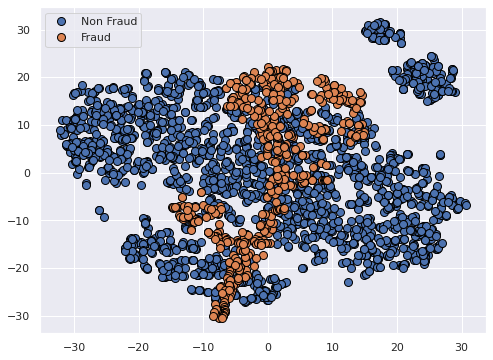

In [ ]:
# IGNORE COMPLETELY -> WRONG LOGIC USED HERE

def plot_embeddings(X_nf_embedded, X_f_embedded):
    # Plotting Begins
    plt.subplots(figsize = (8,6))
    plt.plot(X_nf_embedded[:,0], X_nf_embedded[:,1],'o', mec = "black", mew=1, ms = 8, label = "Non Fraud")
    plt.plot(X_f_embedded[:,0], X_f_embedded[:,1], 'o', mec = "black", mew=1, ms = 8, label = "Fraud")
    plt.legend()
    plt.show()

# Get the fraud and Non-Fraud Cases from test dataset
X_nf = torch.tensor(np.array(X_test), dtype = torch.float32)[:2000]
X_f = torch.tensor(np.array(df[df['Class']==1].drop("Class", axis = 1)), dtype = torch.float32)

# Get their embeddings
X_nf_hidden = model.encoder_layer(X_nf).detach().numpy()
X_f_hidden = model.encoder_layer(X_f).detach().numpy()

# Plot Them
from MulticoreTSNE import MulticoreTSNE as tsne
tsne = tsne(n_components = 2, n_jobs = 2)
X_f_embedded = tsne.fit_transform(X_f_hidden)
X_nf_embedded= tsne.fit_transform(X_nf_hidden)

plot_embeddings(X_nf_embedded, X_f_embedded)